In [3]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [4]:
!wget --no-check-certificate \
    "https://github.com/cikafaza/Capstone_Project/archive/refs/heads/main.zip" \
    -O "/tmp/eye-disease.zip"


zip_ref = zipfile.ZipFile('/tmp/eye-disease.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-06-11 13:39:42--  https://github.com/cikafaza/Capstone_Project/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/cikafaza/Capstone_Project/zip/refs/heads/main [following]
--2022-06-11 13:39:42--  https://codeload.github.com/cikafaza/Capstone_Project/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/eye-disease.zip’

/tmp/eye-disease.zi     [               <=>  ]  26.71M  8.33MB/s    in 3.2s    

2022-06-11 13:39:46 (8.33 MB/s) - ‘/tmp/eye-disease.zip’ saved [28009127]



In [5]:
# Set the Path for your training and test data ser
PATH = "/tmp/Capstone_Project-main/Capstone_Eye_Diseases_Dataset"
data_dir_list = os.listdir(PATH)
data_dir_list

['train', 'test']

In [6]:
# Define the train and test base directories
train_dir = PATH + '/train'
validation_dir = PATH + '/test'

# Directory with training cataract pictures
train_cataract_dir = os.path.join(train_dir, 'cataract')
# Directory with training normal pictures
train_normal_dir = os.path.join(train_dir, 'normal')
# Directory with training conjunctivitis pictures
train_conjunctivitis_dir = os.path.join(train_dir, 'conjunctivitis')
# Directory with training ocular_herpes pictures
train_ocular_herpes_dir = os.path.join(train_dir, 'ocular_herpes')
# Directory with validation cataract pictures
validation_cataract_dir = os.path.join(validation_dir, 'cataract')
# Directory with validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'normal')
# Directory with validation conjunctivitis pictures
validation_conjunctivitis_dir = os.path.join(validation_dir, 'conjunctivitis')
# Directory with validation ocular_herpes pictures
validation_ocular_herpes_dir = os.path.join(validation_dir, 'ocular_herpes')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_cataract_dir))} images of cataract for training.\n")
print(f"There are {len(os.listdir(train_normal_dir))} images of normal for training.\n")
print(f"There are {len(os.listdir(train_conjunctivitis_dir))} images of conjunctivitis for training.\n")
print(f"There are {len(os.listdir(train_ocular_herpes_dir))} images of ocular_herpes for training.\n")
print(f"There are {len(os.listdir(validation_cataract_dir))} images of cataract for validation.\n")
print(f"There are {len(os.listdir(validation_normal_dir))} images of normal for validation.\n")
print(f"There are {len(os.listdir(validation_conjunctivitis_dir))} images of conjunctivitis for validation.\n")
print(f"There are {len(os.listdir(validation_ocular_herpes_dir))} images of ocular_herpes for validation.\n")

There are 160 images of cataract for training.

There are 160 images of normal for training.

There are 160 images of conjunctivitis for training.

There are 160 images of ocular_herpes for training.

There are 40 images of cataract for validation.

There are 40 images of normal for validation.

There are 40 images of conjunctivitis for validation.

There are 40 images of ocular_herpes for validation.



Sample cataract image:


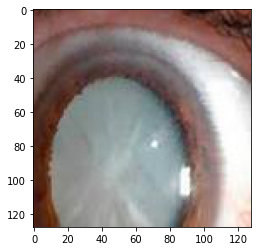


Sample normal image:


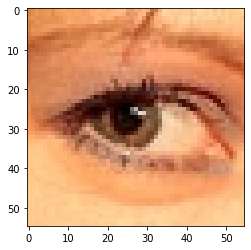


Sample conjunctivitis image:


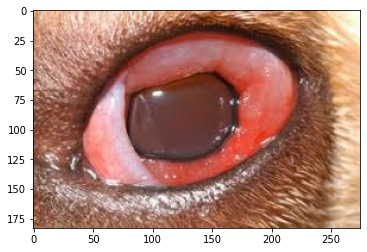


Sample ocular_herpes image:


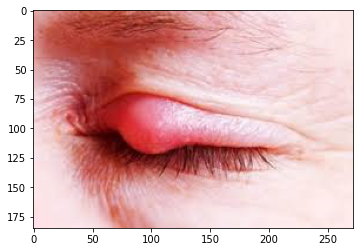

In [7]:
print("Sample cataract image:")
plt.imshow(load_img(f"{os.path.join(train_cataract_dir, os.listdir(train_cataract_dir)[0])}"))
plt.show()

print("\nSample normal image:")
plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])}"))
plt.show()

print("\nSample conjunctivitis image:")
plt.imshow(load_img(f"{os.path.join(train_conjunctivitis_dir, os.listdir(train_conjunctivitis_dir)[0])}"))
plt.show()

print("\nSample ocular_herpes image:")
plt.imshow(load_img(f"{os.path.join(train_ocular_herpes_dir, os.listdir(train_ocular_herpes_dir)[0])}"))
plt.show()

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
  
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=8, 
                                                      class_mode='categorical',
                                                      target_size=(150, 150))
  
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=8, 
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 640 images belonging to 4 classes.
Found 160 images belonging to 4 classes.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [11]:
# Define a Callback class that stops training once validation accuracy reaches 80%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.80):
      print("\nReached 80% validation accuracy so cancelling training!")
      self.model.stop_training = True

In [12]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/20
80/80 [==============================] - 17s 63ms/step - loss: 1.4005 - accuracy: 0.2703 - val_loss: 1.3894 - val_accuracy: 0.2688
Epoch 2/20
80/80 [==============================] - 5s 61ms/step - loss: 1.3475 - accuracy: 0.3406 - val_loss: 1.3586 - val_accuracy: 0.3750
Epoch 3/20
80/80 [==============================] - 5s 61ms/step - loss: 1.2574 - accuracy: 0.4500 - val_loss: 1.2845 - val_accuracy: 0.4000
Epoch 4/20
80/80 [==============================] - 5s 60ms/step - loss: 1.1936 - accuracy: 0.4672 - val_loss: 1.1660 - val_accuracy: 0.4187
Epoch 5/20
80/80 [==============================] - 5s 61ms/step - loss: 1.1422 - accuracy: 0.5109 - val_loss: 1.1665 - val_accuracy: 0.4250
Epoch 6/20
80/80 [==============================] - 5s 60ms/step - loss: 1.1032 - accuracy: 0.5375 - val_loss: 1.0957 - val_accuracy: 0.5188
Epoch 7/20
80/80 [==============================] - 5s 61ms/step - loss: 1.0912 - accuracy: 0.5172 - val_loss: 1.1639 - val_accuracy: 0.4812
Epoch 8/20
8

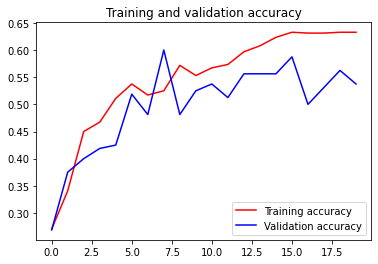

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [14]:
validation_generator.class_indices

{'cataract': 0, 'conjunctivitis': 1, 'normal': 2, 'ocular_herpes': 3}

Saving 2.jpg to 2 (2).jpg
Saving 6.jpg to 6 (3).jpg
Saving download (19).jpg to download (19) (4).jpg
Saving htest23.jpg to htest23 (5).jpg
Saving images - 2020-10-26T225409.928.jpg to images - 2020-10-26T225409.928 (3).jpg
Saving images - 2020-10-26T225410.668.jpg to images - 2020-10-26T225410.668 (3).jpg
Saving images22.jpg to images22 (4).jpg
Saving images41.jpg to images41 (4).jpg
Saving images52.jpg to images52 (4).jpg


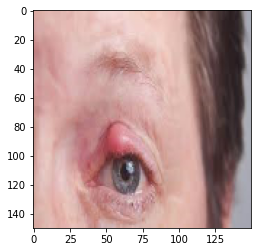

2.jpg
[[0.0000000e+00 9.9984252e-01 0.0000000e+00 1.5744347e-04]]


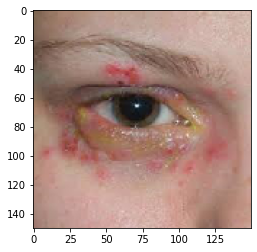

6.jpg
[[0. 1. 0. 0.]]


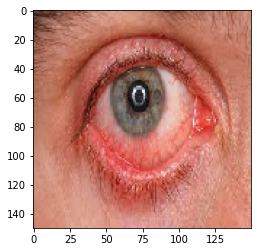

download (19).jpg
[[0. 1. 0. 0.]]


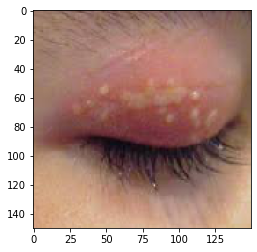

htest23.jpg
[[0. 1. 0. 0.]]


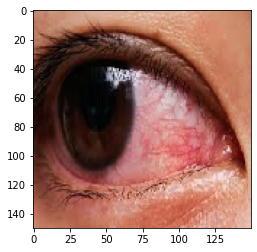

images - 2020-10-26T225409.928.jpg
[[0. 1. 0. 0.]]


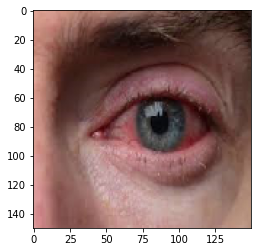

images - 2020-10-26T225410.668.jpg
[[0. 1. 0. 0.]]


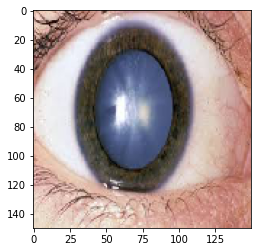

images22.jpg
[[1. 0. 0. 0.]]


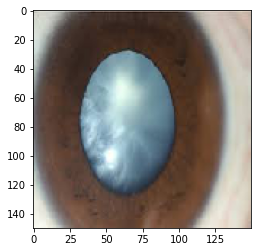

images41.jpg
[[1. 0. 0. 0.]]


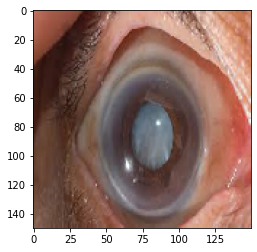

images52.jpg
[[1. 0. 0. 0.]]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  print(classes)

Exporting to **TFLite**

In [21]:
import pathlib

In [22]:
#Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


In [23]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [24]:
#Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [25]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

9511648